In [1]:
import os                                                           # Provides functions to control pathing
import random                                                       # Needed to randomly sample images
import numpy as np                                                  # Used for clipping images in test evaluation
import matplotlib.pyplot as plt                                     # Plotting data
import seaborn as sns                                               # Visualizing through heatmaps
from PIL import Image                                               # Image preprocessing
from sklearn.metrics import confusion_matrix, classification_report # Evaluation metrics
from sklearn.model_selection import train_test_split                # Premade split for the data
import torch                                                        # Provides PyTorch functionality
import torch.optim as optim                                         # Provides an optimizer for training
import torch.nn as nn                                               # Provides CNN functions
from torch.utils.data import Dataset, DataLoader                    # Provides classes required for the model
import torchvision.transforms as transforms                         # Simple multi-transforms
import pandas as pd

In [2]:
# Various constants and parameters
train, test = 'Training', 'Testing'
target_size = (224, 224)
random_state = 42
batch_size = 32
num_classes = 4
device = "cuda" if torch.cuda.is_available() else "cpu"
label_map = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}

In [1]:
import kagglehub  # Loads the dataset straight from Kaggle (no actual download required)
base_directory = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", base_directory)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [4]:
categories = os.listdir(base_directory + '/' + train) # OS package can splice together strings to get a path and list folder contents
print(categories)

['pituitary', 'notumor', 'meningioma', 'glioma']


In [5]:
# Function for plotting random images from either the test or training folder
def display_images(dataset_type, num_images=4, image_size=(224, 224)):

    dataset_path = os.path.join(base_directory, dataset_type)                   # Get into either train or test folder

    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))     # Create plots

    for row, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)                    # Get into folder for each category
        image_filenames = random.sample(os.listdir(category_path), num_images)  # Select random images

        for col, image_filename in enumerate(image_filenames):
            while image_filename == '.DS_Store':                                # While the file chosen is garbage, randomly pick another
                image_filename = random.sample(os.listdir(category_path), 1)[0]
            image_path = os.path.join(category_path, image_filename)
            image = Image.open(image_path).resize(image_size)                   # Open and resize the selected image
            axes[row, col].imshow(image, cmap='gray')                           # Add image to the plot
            axes[row, col].axis('off')
            axes[row, col].set_title(f"{category}")

    plt.tight_layout()
    plt.show()

In [6]:
# Function for plotting the distributions of each type of tumor in test or training set
def plot_class_distribution(dataset_type):
    path = os.path.join(base_directory, dataset_type)                               # Get path for either training or test folder
    counts = [len(os.listdir(os.path.join(path, cat))) for cat in categories]       # Count how many images are in each category folder

    plt.bar(categories, counts, color = ['navy', 'teal', 'darkorange', 'crimson'])  # Plot the distribution
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{dataset_type.capitalize()} Set Distribution")
    plt.show()

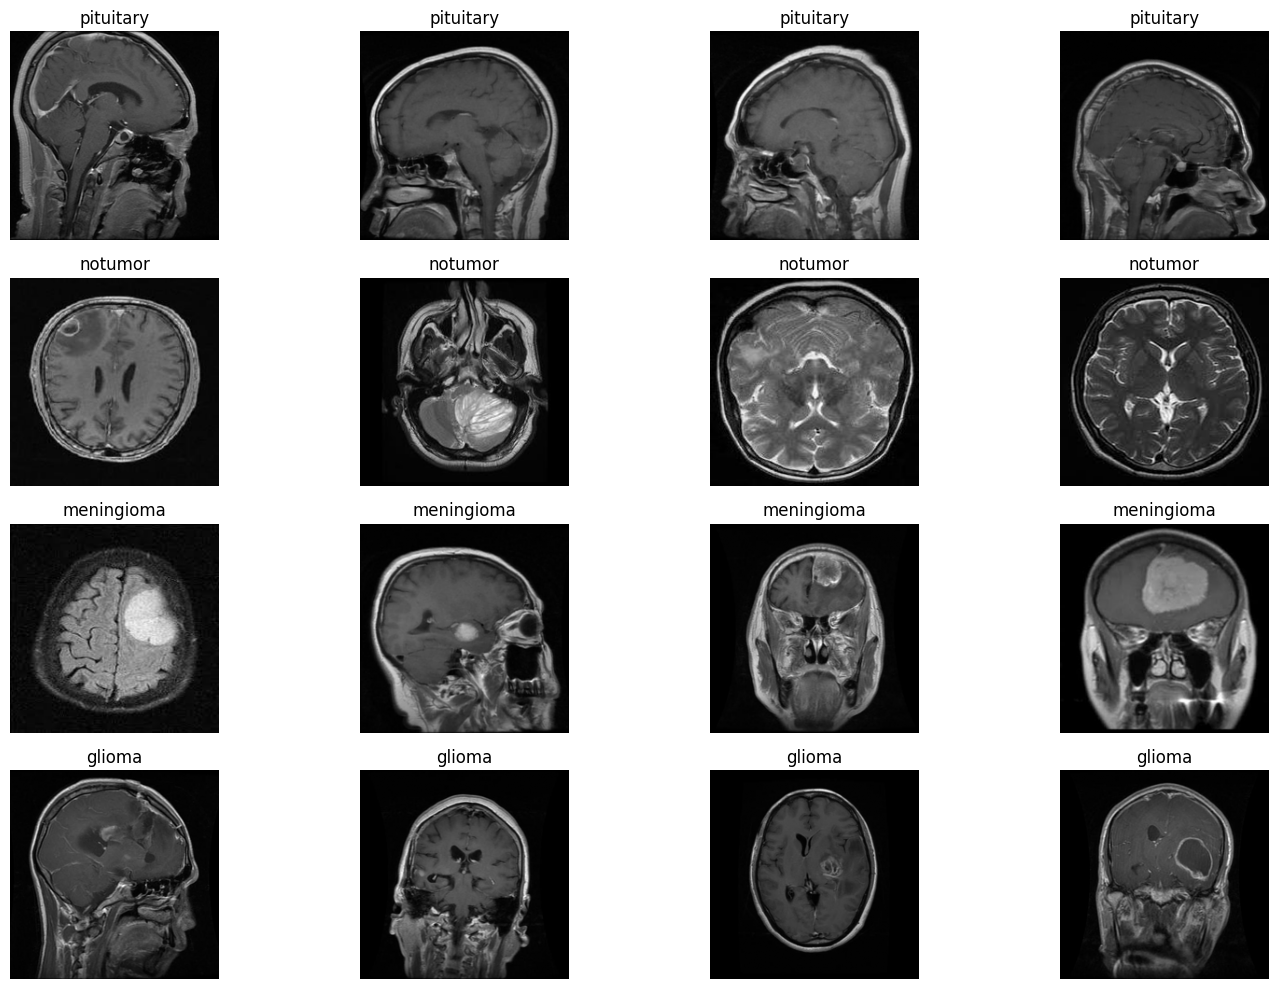

In [7]:
display_images(train)

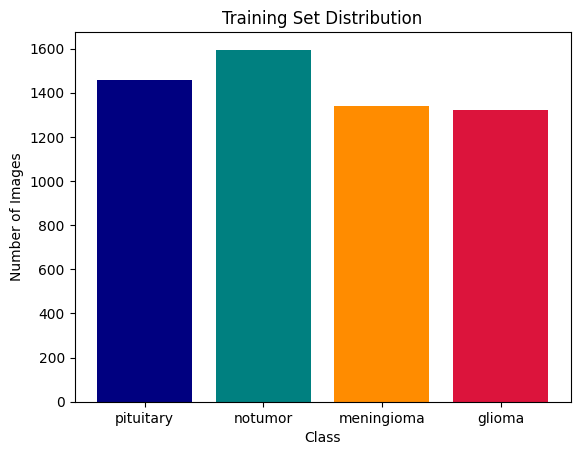

In [8]:
plot_class_distribution(train)

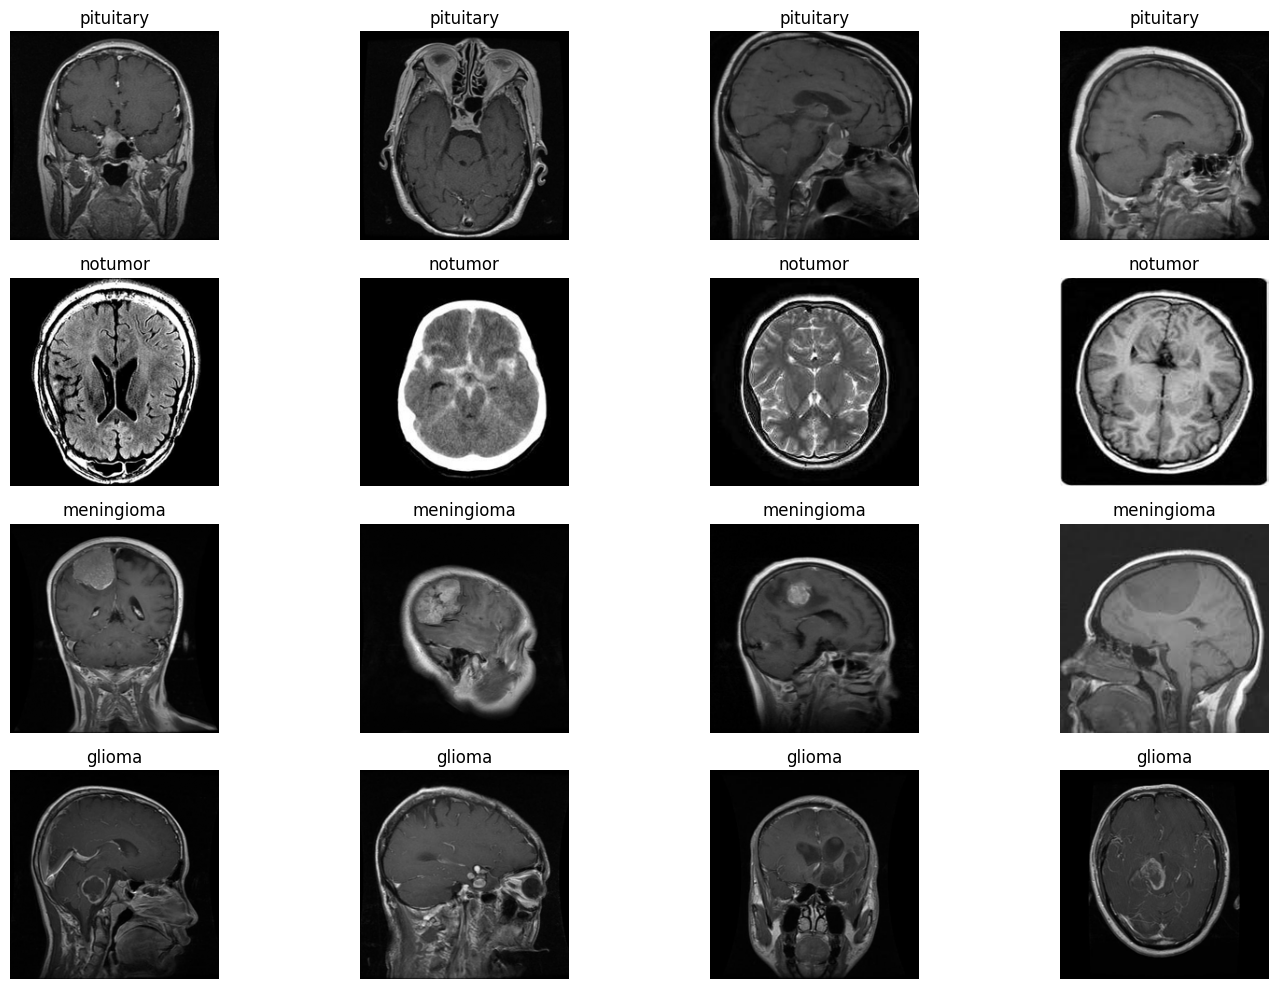

In [9]:
display_images(test)

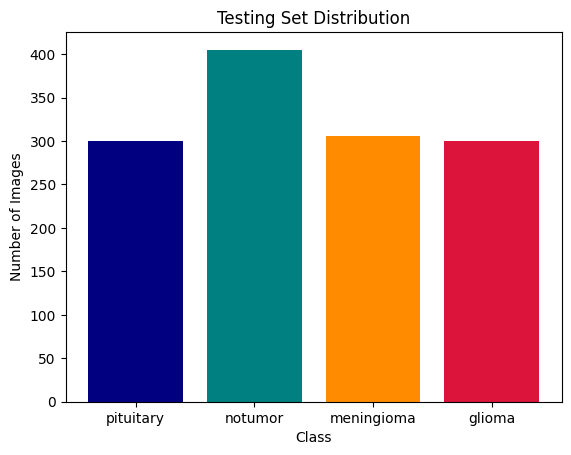

In [10]:
plot_class_distribution(test)

In [11]:
def create_dataset(path):
    my_list = []
    for category in categories:
        category_path = os.path.join(path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensure we're only adding image files
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])

In [12]:
train_df = create_dataset(base_directory+'/'+train)
test_df = create_dataset(base_directory+'/'+test)

train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

In [13]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [14]:
train_transform = transforms.Compose([

   transforms.Resize(target_size),
   transforms.RandomHorizontalFlip(),
   transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
   transforms.ColorJitter(brightness=(0.8, 1.2)),
   transforms.RandomRotation(10),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
test_df_split, val_df_split = train_test_split(test_df, test_size=0.5, random_state=random_state)
# Reset indices for consistency
test_df_split = test_df_split.reset_index(drop=True)
val_df_split = val_df_split.reset_index(drop=True)

In [16]:
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df_split, transform=test_transform)
test_dataset = ImageDataset(test_df_split, transform=test_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # (3, 64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (64, 128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # (128, 256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # (256, 512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # (512, 512)


        # Final shape after pool: (B, 256, 7, 7)
        self.flatten = nn.Flatten() #(256 x 7 x 7) -> (1 x 1 x (256 * 7 * 7))
        self.fc1 = nn.Linear(512 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes) #num_classes: number of output types

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # (3 x 224 x 224) -> (B, 64, 112, 112)
        x = self.pool(self.relu(self.conv2(x)))  # (B, 64, 112, 112) -> (B, 128, 56, 56)
        x = self.pool(self.relu(self.conv3(x)))  # (B, 128, 56, 56) -> (B, 256, 28, 28)
        x = self.pool(self.relu(self.conv4(x)))  # (B, 256, 28, 28) -> (B, 512, 14, 14)
        x = self.pool(self.relu(self.conv5(x)))  # (B, 512, 14, 14) -> (B, 512, 7, 7)


        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [18]:
model = BrainTumorCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, name='model', patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")
    tolerance = 0  # Counter for early stopping
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print("#" * 80)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_brain_tumor_{name}.pth')
            tolerance = 0
        else:
            tolerance += 1
            if tolerance >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return history

In [20]:
print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

Starting training...
Epoch [1/30]
Train Loss: 0.9800, Train Accuracy: 57.16%
Val Loss: 0.7531, Val Accuracy: 72.26%
################################################################################
Epoch [2/30]
Train Loss: 0.6480, Train Accuracy: 72.74%
Val Loss: 0.5844, Val Accuracy: 75.15%
################################################################################
Epoch [3/30]
Train Loss: 0.5033, Train Accuracy: 80.48%
Val Loss: 0.4832, Val Accuracy: 80.64%
################################################################################
Epoch [4/30]
Train Loss: 0.3983, Train Accuracy: 84.84%
Val Loss: 0.4106, Val Accuracy: 83.99%
################################################################################
Epoch [5/30]
Train Loss: 0.3242, Train Accuracy: 87.92%
Val Loss: 0.3648, Val Accuracy: 86.59%
################################################################################
Epoch [6/30]
Train Loss: 0.2817, Train Accuracy: 89.97%
Val Loss: 0.2830, Val Accuracy: 87.35%
####

In [21]:
def plot_training_history(history, model_name="model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

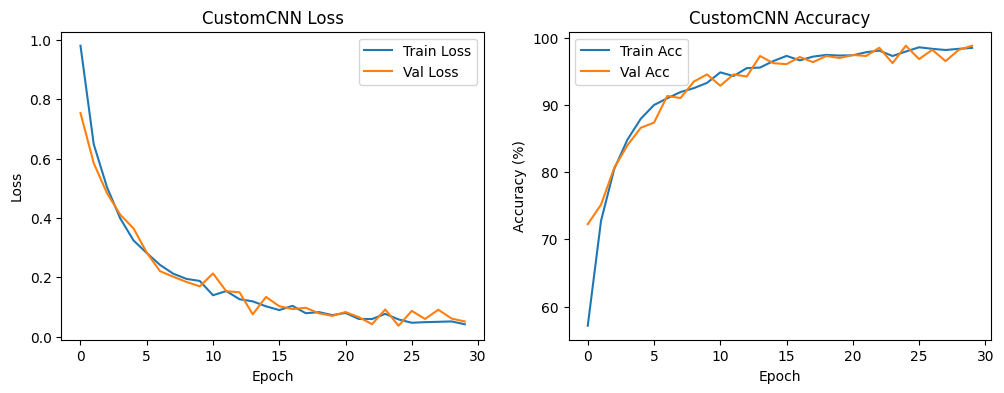

In [22]:
plot_training_history(history, model_name="CustomCNN")

In [23]:
def test_model(model, test_loader, num_images_to_show=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())  # Store images for visualization

    test_acc = 100 * correct / total

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {test_acc:.2f}%\n")

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=categories))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Loading best model for testing...
Test Accuracy: 98.93%

Classification Report:

              precision    recall  f1-score   support

   pituitary       0.98      1.00      0.99       197
     notumor       0.99      0.99      0.99       151
  meningioma       0.98      0.98      0.98       158
      glioma       1.00      0.99      0.99       149

    accuracy                           0.99       655
   macro avg       0.99      0.99      0.99       655
weighted avg       0.99      0.99      0.99       655



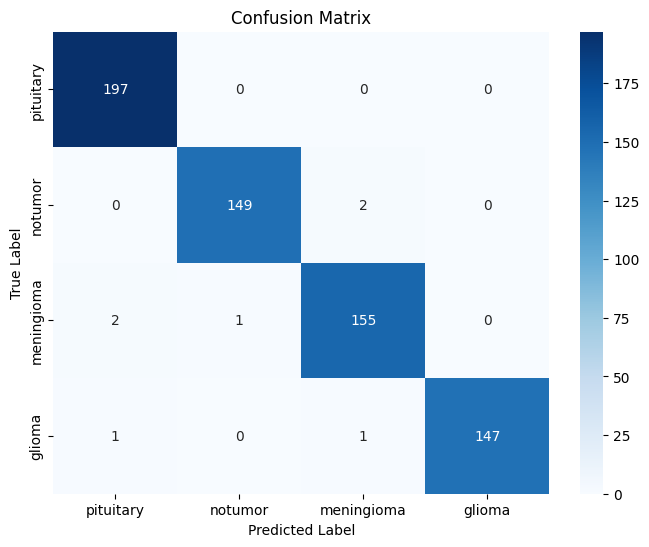

In [24]:
print("\nLoading best model for testing...")
model.load_state_dict(torch.load('best_brain_tumor_model.pth'))
test_model(model, test_loader)

In [25]:
from google.colab import files
files.download('best_brain_tumor_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>